# Final Project Sketch :(


In [1]:
import pandas as pd
import numpy as np
import os
from math import sin, cos, sqrt, atan2, radians
import datetime
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./My Project 14295-223aab171173.json"
from google.cloud import bigquery
client = bigquery.Client()
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
#from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='zxf71699', api_key='BkltlyEFcOkOAgCSdkjt')
import seaborn as sns
import matplotlib.pyplot as plt 
import time

Loading BokehJS ...

## Query Data from BigQuery

In [57]:
start = time.time()
query = (
"""
SELECT date_of_year, month_of_year, day_of_year, pickup_hour,
    dropoff_datetime,pickup_datetime,
    pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude, travel_time,
    temp, visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date_of_year, pickup_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude,
            EXTRACT (HOUR FROM pickup_datetime) as pickup_hour,
            EXTRACT (DAY FROM pickup_datetime) as day_of_year,
            EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
            EXTRACT (DATE FROM pickup_datetime) as date_of_year,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and
                dropoff_longitude IS NOT NULL and dropoff_latitude IS NOT NULL
      ) x
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) y on x.month_of_year = y.month and x.day_of_year = y.day
where x.row_number <= 200
"""
)
data=pd.io.gbq.read_gbq(query,dialect='standard')
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Time taken by above cell is 3.933226164182027.


In [3]:
data.head()
data.to_csv("data.csv",index = False)

In [33]:
df = pd.read_csv("./data.csv")

In [34]:
df.pickup_datetime = pd.to_datetime(df['pickup_datetime'])

# Summary of Data

In [58]:
# Return high level information about data
data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871016 entries, 0 to 32117
Data columns (total 25 columns):
date_of_year         871016 non-null datetime64[ns]
month_of_year        871016 non-null int64
day_of_year          871016 non-null int64
pickup_hour          871016 non-null int64
dropoff_datetime     871016 non-null datetime64[ns]
pickup_datetime      871016 non-null datetime64[ns]
pickup_longitude     871016 non-null float64
pickup_latitude      871016 non-null float64
dropoff_longitude    871016 non-null float64
dropoff_latitude     871016 non-null float64
travel_time          871016 non-null int64
temp                 871016 non-null float64
visib                871016 non-null float64
mxpsd                871016 non-null object
wdsp                 871016 non-null object
gust                 871016 non-null float64
max                  871016 non-null float64
min                  871016 non-null float64
prcp                 871016 non-null float64
sndp                 871

## Calculate Distance 

In [59]:
R = 6373.0

dlon = np.radians(data['dropoff_longitude']) - np.radians(data['pickup_longitude'])
dlat = np.radians(data['dropoff_latitude']) - np.radians(data['pickup_latitude'])

#a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#c = 2 * atan2(sqrt(a), sqrt(1 - a))

a = np.sin(dlat / 2)**2 + np.cos(data['pickup_latitude']) * np.cos(data['pickup_longitude']) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

data['distance_in_km'] = R*c
data.head()

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in sqrt



date_of_year  month_of_year  day_of_year  pickup_hour    dropoff_datetime  \
0   2016-01-23              1           23           22 2016-01-23 22:28:15   
1   2016-01-23              1           23           22 2016-01-23 22:44:11   
2   2016-01-23              1           23           22 2016-01-23 22:23:43   
3   2016-01-23              1           23           22 2016-01-23 22:25:18   
4   2016-01-23              1           23           22 2016-01-23 22:25:39   

      pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  \
0 2016-01-23 22:18:51        -74.004860        40.706886         -73.989311   
1 2016-01-23 22:38:56        -74.000771        40.718445         -73.999222   
2 2016-01-23 22:14:49        -73.907150        40.760212         -73.898651   
3 2016-01-23 22:18:03        -73.957603        40.620747         -73.970451   
4 2016-01-23 22:09:41        -74.005287        40.728111         -73.983391   

   dropoff_latitude  travel_time  temp  visib mxpsd  wdsp  gust   max   min  \
0         40.721378          564  26.2    1.7  20.0  12.8  36.9  30.0  21.0   
1         40.719875          315  26.2    1.7  20.0  12.8  36.9  30.0  21.0   
2         40.749737          534  26.2    1.7  20.0  12.8  36.9  30.0  21.0   
3         40.616898          435  26.2    1.7  20.0  12.8  36.9  30.0  21.0   
4         40.721684          958  26.2    1.7  20.0  12.8  36.9  30.0  21.0   

   prcp   sndp fog rain_drizzle snow_ice_pellets hail thunder  distance_in_km  
0   0.5  999.9   1            0                1    0       0        1.440539  
1   0.5  999.9   1            0                1    0       0        0.142258  
2   0.5  999.9   1            0                1    0       0        1.134298  
3   0.5  999.9   1            0                1    0       0             NaN  
4   0.5  999.9   1            0                1    0       0             NaN

## Optimize the memory usage

In [60]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

Original memory usage:  507.15 MB
After converting int and float memory usage:  93.03 MB


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871016 entries, 0 to 32117
Data columns (total 26 columns):
date_of_year         871016 non-null datetime64[ns]
month_of_year        871016 non-null uint8
day_of_year          871016 non-null uint8
pickup_hour          871016 non-null uint8
dropoff_datetime     871016 non-null datetime64[ns]
pickup_datetime      871016 non-null datetime64[ns]
pickup_longitude     871016 non-null float32
pickup_latitude      871016 non-null float32
dropoff_longitude    871016 non-null float32
dropoff_latitude     871016 non-null float32
travel_time          871016 non-null int64
temp                 871016 non-null float32
visib                871016 non-null float32
mxpsd                871016 non-null float64
wdsp                 871016 non-null float64
gust                 871016 non-null float32
max                  871016 non-null float32
min                  871016 non-null float32
prcp                 871016 non-null float32
sndp                 8

## Process Missing Data & Outlier

### Latitude and Longitude

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



Time taken by above cell is 0.8493211269378662.


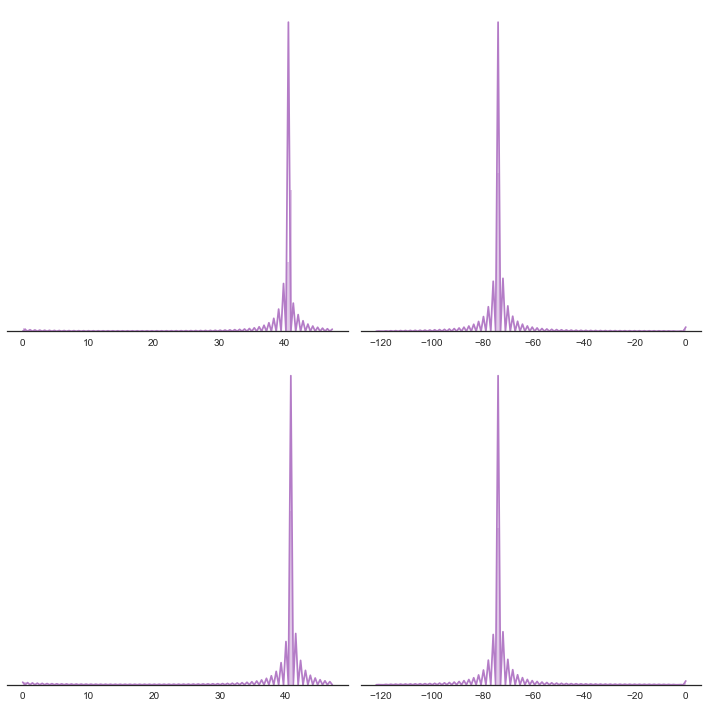

In [62]:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(data['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(data['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(data['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(data['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

### Filter outliers of locations

In [63]:
#data['pickup_latitude'].hist(bins=20)
#data['pickup_longitude'].hist(bins=20)

data = data[(data['pickup_longitude'] >= -79.7624) & (data['pickup_longitude'] <= -71.7517) &
                    (data['pickup_latitude'] >= 40.4772) & (data['pickup_latitude'] <= 45.0153)]

data = data[(data['dropoff_longitude'] >= -79.7624) & (data['dropoff_longitude'] <= -71.7517) &
                    (data['dropoff_latitude'] >= 40.4772) & (data['dropoff_latitude'] <= 45.0153)]

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



Time taken by above cell is 1.0197970867156982.


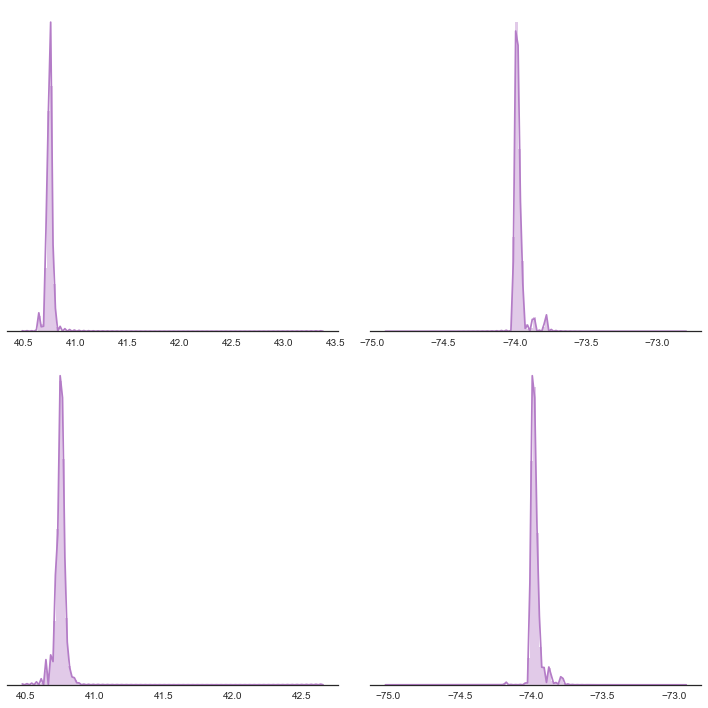

In [64]:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(data['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(data['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(data['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(data['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

### Distance

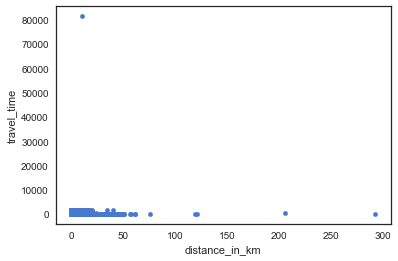

In [65]:
data['travel_time'] = data.travel_time/60
data.plot(x='distance_in_km',y='travel_time',kind='scatter')

In [66]:
data["weekday"] = data['pickup_datetime'].dt.dayofweek # Set day of week
data_small = data.loc[data['distance_in_km'] > 0.1,]

In [67]:
data = data.loc[(data['travel_time']>0) & (data['distance_in_km']<50)  &  (data['travel_time'] > 2) & (data['travel_time'] < 1000) ]

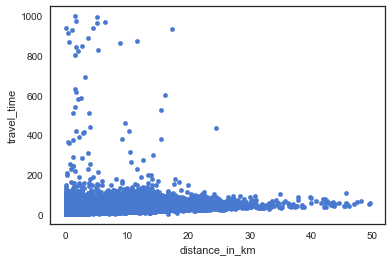

In [68]:
data.plot(x='distance_in_km',y='travel_time',kind='scatter')

In [69]:
data1 = data.copy()

### Preprocessing Weather variables

In [70]:
# refit visib 
for i in data.loc[(data['visib']== 999.9), 'date_of_year'].unique():
    data.loc[data['date_of_year'] == i,'visib'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'visib'].unique()

In [71]:
# refit mxpsd
for i in data.loc[(data['mxpsd']== 999.9), 'date_of_year'].unique():
    data.loc[data['date_of_year'] == i,'mxpsd'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'mxpsd'].unique()

In [72]:
# refit gust
for i in data.loc[(data['gust']== 999.9), 'date_of_year'].unique():
    data.loc[data['date_of_year'] == i,'gust'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'gust'].unique()

In [73]:
# refit sndp
data.loc[data['sndp'] == 999.9,'sndp'] =  0

In [74]:
data.loc[data['sndp']== 999.9, ['date_of_year','temp', 'visib', 'mxpsd', 'wdsp', 'gust', 'max', 'min',
       'prcp', 'sndp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail',
       'thunder', 'weekday']].drop_duplicates().head(20)

Empty DataFrame
Columns: [date_of_year, temp, visib, mxpsd, wdsp, gust, max, min, prcp, sndp, fog, rain_drizzle, snow_ice_pellets, hail, thunder, weekday]
Index: []

In [75]:
data.loc[data['date_of_year'] == x[0]].drop_duplicates().head()

NameError: name 'x' is not defined

In [76]:
data[['date_of_year','temp', 'visib', 'mxpsd', 'wdsp', 'gust', 'max', 'min',
       'prcp', 'sndp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail',
       'thunder', 'weekday']].drop_duplicates().head(20)

date_of_year       temp  visib  mxpsd  wdsp       gust        max  \
0       2016-01-23  26.200001    1.7   20.0  12.8  36.900002  30.000000   
11      2016-01-24  26.700001    7.4   17.1   6.3  26.000000  35.099998   
7181    2016-04-05  33.000000   10.0   13.0   7.9  24.100000  42.099998   
11981   2016-04-06  37.900002   10.0   14.0   4.9  24.100000  48.000000   
16781   2016-04-07  52.400002    9.3   11.1   5.8  22.900000  57.900002   
21582   2016-04-08  47.299999   10.0   11.1   6.7  25.100000  57.900002   
26383   2016-04-09  40.000000    9.1    8.9   4.9  15.900000  50.000000   
31181   2016-04-10  39.599998   10.0    8.0   4.4  17.100000  50.000000   
35981   2016-04-11  50.900002    9.3    9.9   5.6  18.100000  64.900002   
40782   2016-04-12  54.000000    9.1    8.9   5.3  22.000000  64.900002   
1459    2016-04-13  47.700001   10.0   12.0   4.1  18.100000  59.000000   
6259    2016-04-14  50.500000   10.0    9.9   4.9  17.100000  62.099998   
11059   2016-04-15  51.700001   10.0    9.9   3.5  15.000000  64.900002   
15859   2016-04-16  53.200001   10.0    9.9   4.5  17.100000  68.000000   
20659   2016-04-17  56.099998   10.0    8.0   2.3  17.100000  75.000000   
25459   2016-04-18  63.799999   10.0    8.9   2.8  17.100000  82.000000   
30259   2016-04-19  66.300003   10.0   12.0   6.4  24.100000  82.000000   
35059   2016-04-20  58.500000   10.0   11.1   5.8  15.900000  73.000000   
39860   2016-04-21  59.500000   10.0   13.0   4.8  18.100000  73.000000   
490     2016-04-22  70.300003    9.7    7.0   3.6  18.100000  79.000000   

             min  prcp  sndp  fog  rain_drizzle  snow_ice_pellets  hail  \
0      21.000000  0.50   0.0    1             0                 1     0   
11     19.900000  1.82   5.9    1             0                 1     0   
7181   26.100000  0.46   0.0    0             0                 0     0   
11981  26.100000  0.00   0.0    0             0                 0     0   
16781  30.000000  0.00   0.0    0             1                 0     0   
21582  42.099998  0.09   0.0    0             0                 0     0   
26383  36.000000  0.01   0.0    0             1                 0     0   
31181  30.900000  0.11   0.0    0             0                 0     0   
35981  30.900000  0.00   0.0    0             1                 0     0   
40782  43.000000  0.04   0.0    0             1                 0     0   
1459   39.900002  0.17   0.0    0             0                 0     0   
6259   43.000000  0.00   0.0    0             0                 0     0   
11059  42.099998  0.00   0.0    0             0                 0     0   
15859  42.099998  0.00   0.0    0             0                 0     0   
20659  43.000000  0.00   0.0    0             0                 0     0   
25459  44.099998  0.00   0.0    0             0                 0     0   
30259  51.099998  0.00   0.0    0             0                 0     0   
35059  48.900002  0.00   0.0    0             0                 0     0   
39860  48.900002  0.00   0.0    0             0                 0     0   
490    48.900002  0.00   0.0    0             0                 0     0   

       thunder  weekday  
0            0        5  
11           0        6  
7181         0        1  
11981        0        2  
16781        0        3  
21582        0        4  
26383        0        5  
31181        0        6  
35981        0        0  
40782        0        1  
1459         0        2  
6259         0        3  
11059        0        4  
15859        0        5  
20659        0        6  
25459        0        0  
30259        0        1  
35059        0        2  
39860        0        3  
490          0        4

In [77]:
data.loc[data['date_of_year'] == x[0],'gust'] = 999.9

NameError: name 'x' is not defined

In [78]:
data.loc[data['date_of_year'] == x[0],'gust']

NameError: name 'x' is not defined

In [79]:
data.head()
data2 = data.copy

# Explorative Data Analysis

In [49]:
sum(np.isnan(data['distance_in_km'] ))

0

### Log Transformation of Trip Duration

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



Time taken by above cell is 0.15627002716064453.


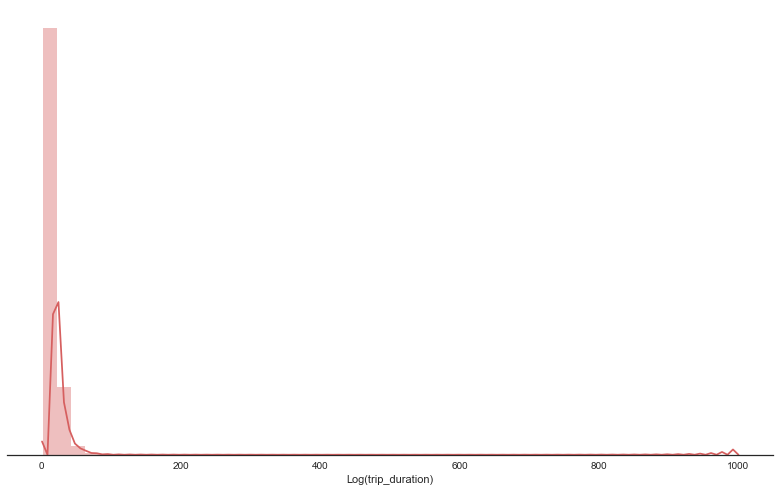

In [80]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(data['travel_time'], axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



Time taken by above cell is 0.14498090744018555.


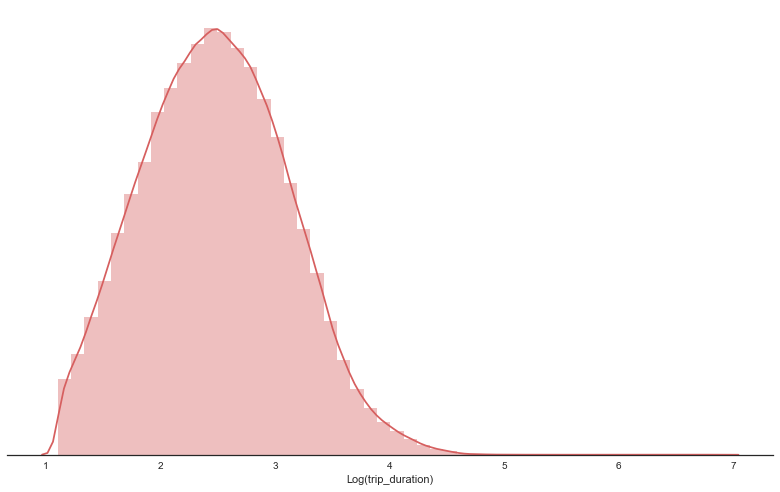

In [81]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(data['travel_time'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

### Histogram of distance

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



Time taken by above cell is 0.19825100898742676.


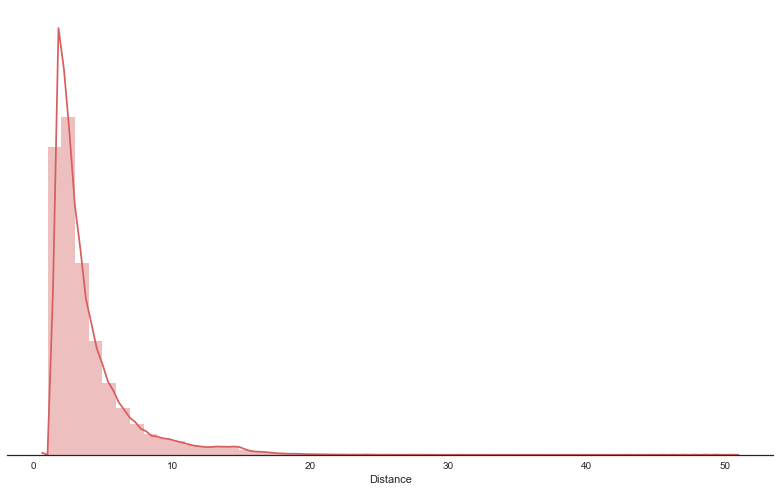

In [82]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(data['distance_in_km'].values+1, axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

### Hourly Durations in Day of Week

In [142]:
df_hour =  data.groupby('pickup_hour')['travel_time'].median()
trace0 = go.Scatter(
    x = np.linspace(0, 23, 24),
    y = df_hour,
    mode = 'lines',
    name = 'lines'
)

df = [trace0]
layout = dict(title = 'Hourly Median Trip Duration',
              xaxis = dict(title = 'Hour'),
              yaxis = dict(title = 'Median Duration'),
              )

fig = dict(data=df, layout=layout)
py.iplot(fig, filename='styled-line')

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



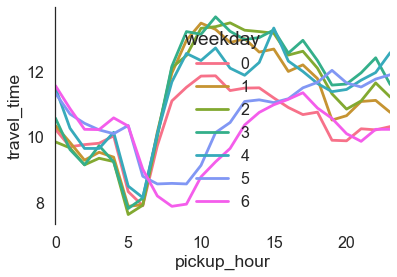

In [84]:
summary_hour_duration = pd.DataFrame(data.groupby(['weekday','pickup_hour'])['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="weekday", value="travel_time")
sns.despine(bottom = True)

In [141]:
summary_hour_duration
data_heatmap = [
    go.Heatmap(
        z=summary_hour_duration.travel_time,
        x=summary_hour_duration.pickup_hour,
        y=summary_hour_duration.weekday,
        colorscale='Viridis',
    )
]

layout = go.Layout(
    title='Hourly duration by weekday',
    xaxis = dict(title = 'Pickup Hours',ticks='', nticks=36),
    yaxis = dict(title = 'Day of Week',ticks='' )
)

fig = go.Figure(data=data_heatmap, layout=layout)
py.iplot(fig, filename='datetime-heatmap')

998.5
Time taken by above cell is 0.2337017059326172.


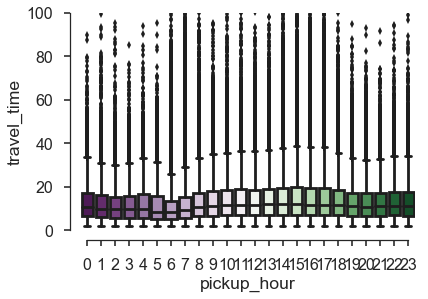

In [85]:
start = time.time()
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="pickup_hour", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 100)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

### Weekly Durations

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



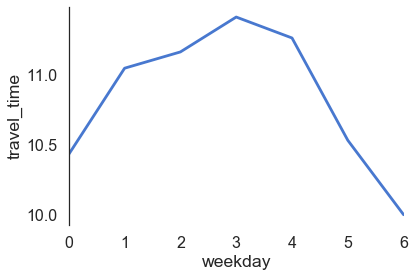

In [86]:
summary_week_duration = pd.DataFrame(data.groupby(['weekday'])['travel_time'].median())
summary_week_duration.reset_index(inplace = True)
summary_week_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_week_duration, time="weekday", unit = "unit", value="travel_time")
sns.despine(bottom = True)

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



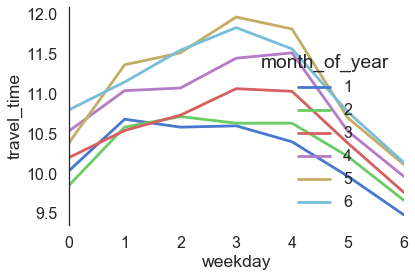

In [112]:
summary_weekday_duration = pd.DataFrame(data.groupby(['weekday','month_of_year'])['travel_time'].median())
summary_weekday_duration.reset_index(inplace = True)
summary_weekday_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_weekday_duration, time="weekday", unit = "unit", condition="month_of_year", value="travel_time")
sns.despine(bottom = True)

In [140]:
summary_hour_duration
data_heatmap = [
    go.Heatmap(
        z=summary_weekday_duration.travel_time,
        x=summary_weekday_duration.weekday,
        y=summary_weekday_duration.month_of_year,
        colorscale='Viridis',
    )
]

layout = go.Layout(
    title='Hourly duration by weekday',
    xaxis = dict(title = 'Day of Week', nticks=14),
    yaxis = dict(title = 'Pickup Month')
)

fig = go.Figure(data=data_heatmap, layout=layout)
py.iplot(fig, filename='datetime-heatmap')

998.5
Time taken by above cell is 0.12358403205871582.


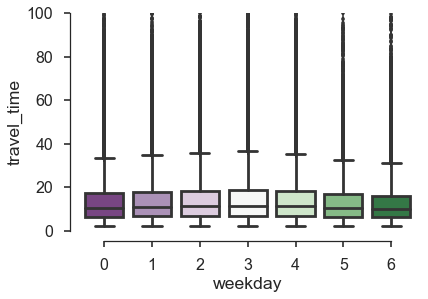

In [87]:
start = time.time()
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="weekday", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 100)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

## Monthly Durations

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



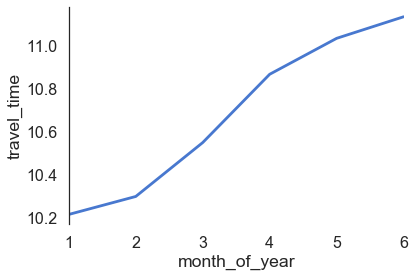

In [111]:
summary_month_duration = pd.DataFrame(data.groupby(['month_of_year'])['travel_time'].median())
summary_month_duration.reset_index(inplace = True)
summary_month_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_month_duration, time="month_of_year", unit = "unit", value="travel_time")
sns.despine(bottom = True)

998.5
Time taken by above cell is 0.10920310020446777.


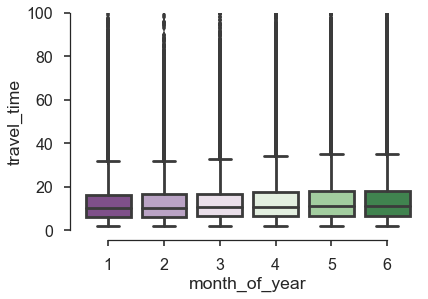

In [125]:
start = time.time()
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="month_of_year", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 100)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

## Geospatial

### Cluster

#### K-Means Cluster

In [88]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

#### Remove outliers of longitude and latitude

In [89]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
data = data[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1])]
data = data[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1])]
data = data[(data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1])]
data = data[(data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1])]

In [90]:
df1 = data.copy()

#### Cluster only location
##### 100 clusters

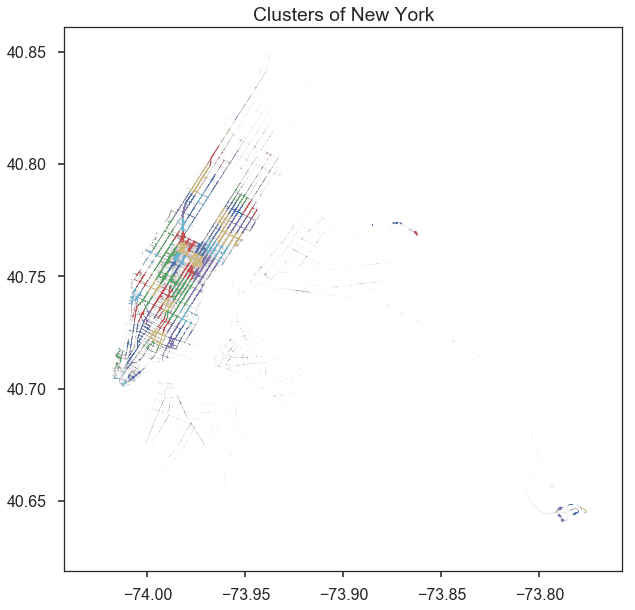

In [91]:
loc_df = pd.DataFrame()
loc_df['longitude'] = data.pickup_longitude
loc_df['latitude'] = data.pickup_latitude

kmeans = KMeans(n_clusters=100, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_


plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

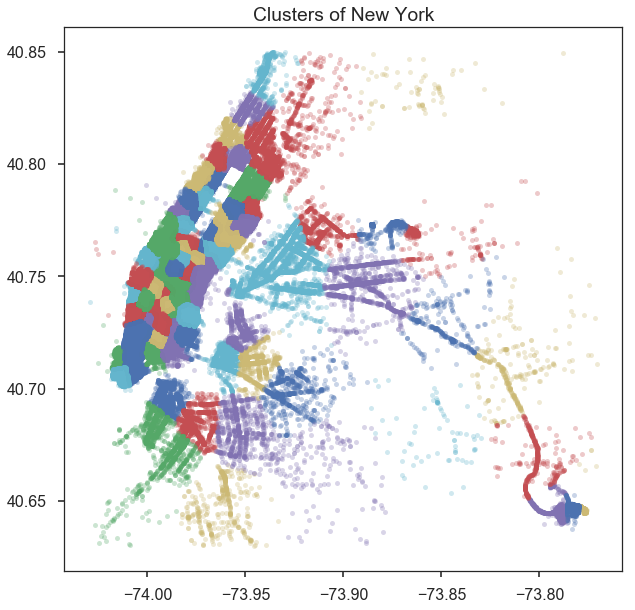

In [92]:
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 10)

plt.title('Clusters of New York')
plt.show()

##### 20 clusters

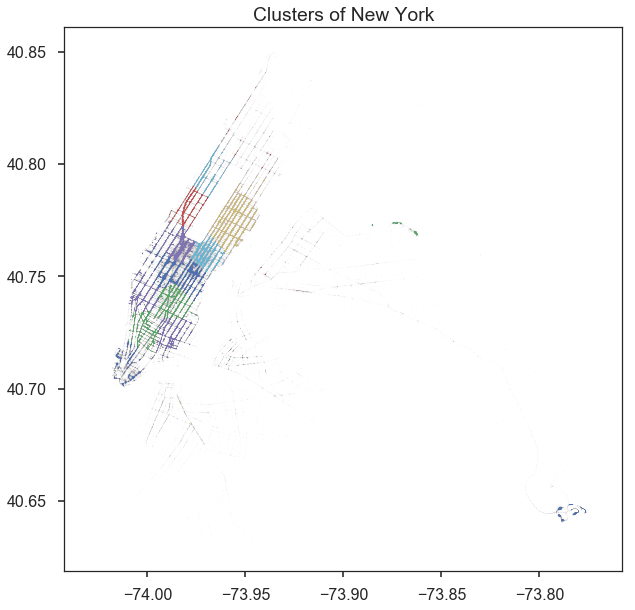

In [93]:
loc_df1 = pd.DataFrame()
loc_df1['longitude'] = data.pickup_longitude
loc_df1['latitude'] = data.pickup_latitude
kmeans1 = KMeans(n_clusters=20, random_state=2, n_init = 10).fit(loc_df1)
loc_df1['label'] = kmeans1.labels_


plt.figure(figsize = (10,10))
for label in loc_df1.label.unique():
    plt.plot(loc_df1.longitude[loc_df1.label == label],loc_df1.latitude[loc_df1.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

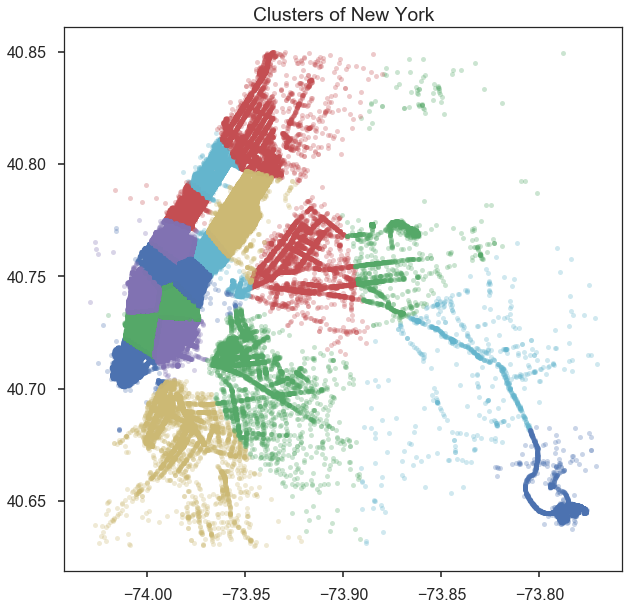

In [94]:
plt.figure(figsize = (10,10))
for label in loc_df1.label.unique():
    plt.plot(loc_df1.longitude[loc_df1.label == label],loc_df1.latitude[loc_df1.label == label],'.', alpha = 0.3, markersize = 10)

plt.title('Clusters of New York')
plt.show()

#### Cluster both pickup and dropoff location and pickup time
##### 100 clusters

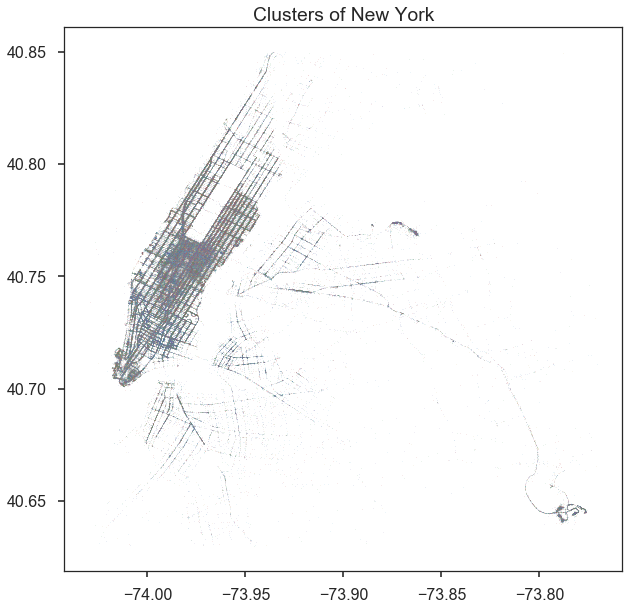

In [95]:
loc_df2 = pd.DataFrame()
loc_df2['longitude'] = data.pickup_longitude
loc_df2['latitude'] = data.pickup_latitude
loc_df2['hour'] = data.pickup_hour
loc_df2['month'] = data.month_of_year
loc_df2['weekday'] = data.weekday
loc_df2["dropoff_lat"] = data.dropoff_latitude
loc_df2['dropoff_long'] = data.dropoff_longitude

kmeans2 = KMeans(n_clusters=100, random_state=2, n_init = 10).fit(loc_df2)
loc_df2['label'] = kmeans2.labels_


plt.figure(figsize = (10,10))
for label in loc_df2.label.unique():
    plt.plot(loc_df2.longitude[loc_df2.label == label],loc_df2.latitude[loc_df2.label == label],'.', alpha = 0.3, markersize = 1)

plt.title('Clusters of New York')
plt.show()

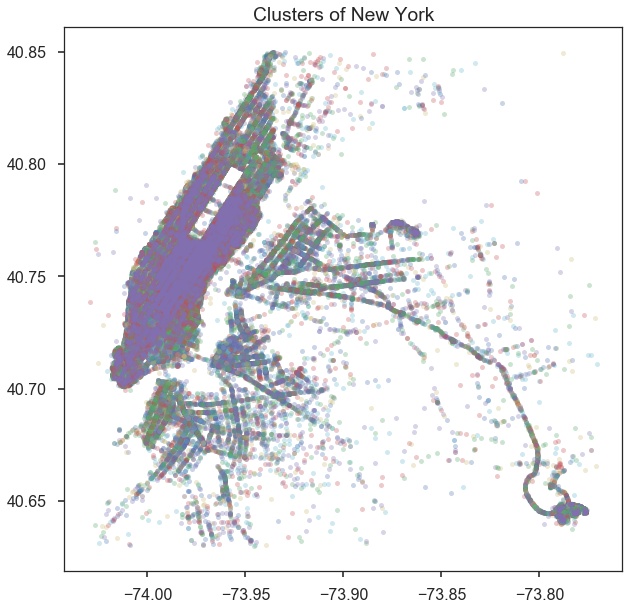

In [97]:
plt.figure(figsize = (10,10))
for label in loc_df2.label.unique():
    plt.plot(loc_df2.longitude[loc_df2.label == label],loc_df1.latitude[loc_df2.label == label],'.', alpha = 0.3, markersize = 10)

plt.title('Clusters of New York')
plt.show()

##### 20 clusters

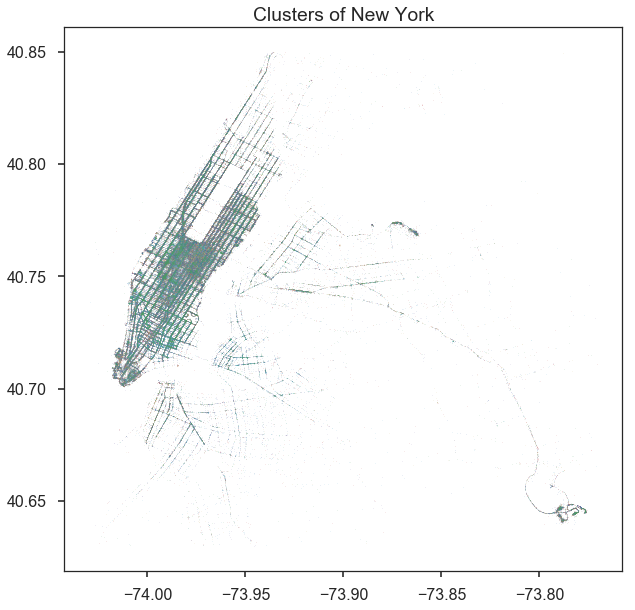

In [98]:
loc_df3 = pd.DataFrame()
loc_df3['longitude'] = data.pickup_longitude
loc_df3['latitude'] = data.pickup_latitude
loc_df3['hour'] = data.pickup_hour
loc_df3['month'] = data.month_of_year
loc_df3['weekday'] = data.weekday
loc_df3["dropoff_lat"] = data.dropoff_latitude
loc_df3['dropoff_long'] = data.dropoff_longitude

kmeans3 = KMeans(n_clusters=20, random_state=2, n_init = 10).fit(loc_df3)
loc_df3['label'] = kmeans3.labels_


plt.figure(figsize = (10,10))
for label in loc_df3.label.unique():
    plt.plot(loc_df3.longitude[loc_df3.label == label],loc_df3.latitude[loc_df3.label == label],'.', alpha = 0.3, markersize = 1)

plt.title('Clusters of New York')
plt.show()

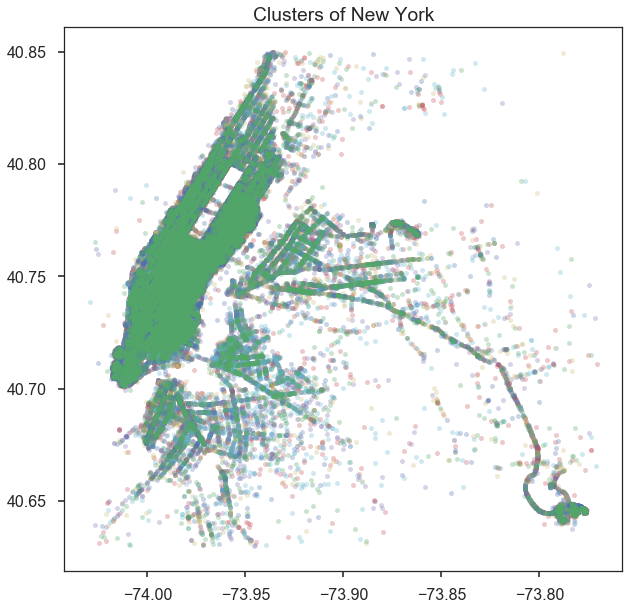

In [99]:
plt.figure(figsize = (10,10))
for label in loc_df3.label.unique():
    plt.plot(loc_df3.longitude[loc_df3.label == label],loc_df3.latitude[loc_df3.label == label],'.', alpha = 0.3, markersize = 10)

plt.title('Clusters of New York')
plt.show()

#### Cluster pickup and dropoff locations

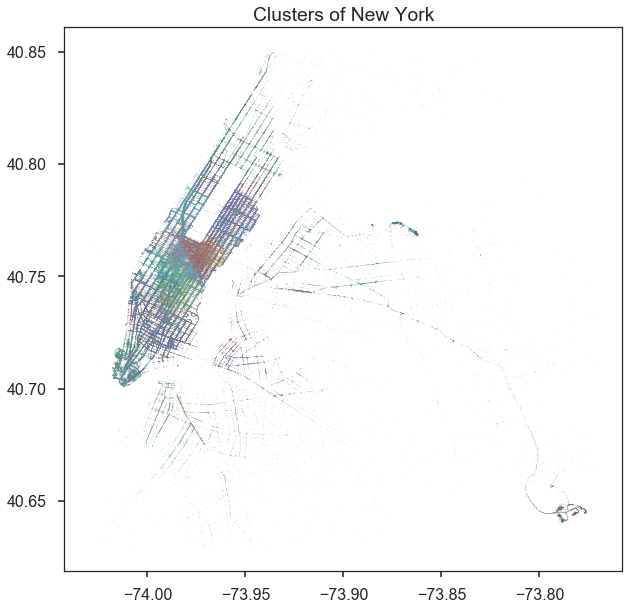

In [102]:
loc_df4 = pd.DataFrame()
loc_df4['longitude'] = data.pickup_longitude
loc_df4['latitude'] = data.pickup_latitude
loc_df4["dropoff_lat"] = data.dropoff_latitude
loc_df4['dropoff_long'] = data.dropoff_longitude

kmeans4 = KMeans(n_clusters=100, random_state=2, n_init = 10).fit(loc_df4)
loc_df4['label'] = kmeans4.labels_


plt.figure(figsize = (10,10))
for label in loc_df4.label.unique():
    plt.plot(loc_df4.longitude[loc_df4.label == label],loc_df4.latitude[loc_df4.label == label],'.', alpha = 0.3, markersize = 1)

plt.title('Clusters of New York')
plt.show()

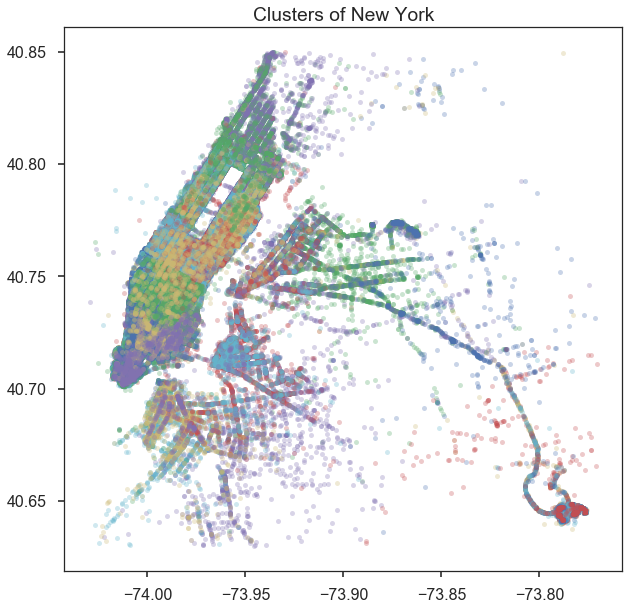

In [103]:
plt.figure(figsize = (10,10))
for label in loc_df4.label.unique():
    plt.plot(loc_df4.longitude[loc_df4.label == label],loc_df4.latitude[loc_df4.label == label],'.', alpha = 0.3, markersize = 10)

plt.title('Clusters of New York')
plt.show()

In [222]:
data['label3'] = loc_df3.label#add labels by your perference
data['label2'] = loc_df2.label
data['label'] = loc_df.label
data['label4'] = loc_df4.label
data['label1'] = loc_df1.label

##### Geohash

In [105]:
from __future__ import print_function, division
import geopandas as gpd
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
import geopandas as gpd
import geohash_hilbert as ghh
import choroplethNYC as cp
#!pip install geohash_hilbert 
#!pip install geopandas 
#!pip install pysal
#!pip install shapely


/Users/franceszhang/anaconda3/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning:

The `dill` module is required to use the sqlite backend fully.



In [106]:
geo = []
for i in range(len(data)):
    value = ghh.encode(df1.pickup_longitude.iloc[i], df1.pickup_latitude.iloc[i], precision=5)
    geo.append(value)
df1['geohash'] = geo
df1['pickups'] = np.ones(df1.shape[0])
df1.head()

date_of_year  month_of_year  day_of_year  pickup_hour    dropoff_datetime  \
0   2016-01-23              1           23           22 2016-01-23 22:28:15   
1   2016-01-23              1           23           22 2016-01-23 22:44:11   
2   2016-01-23              1           23           22 2016-01-23 22:23:43   
8   2016-01-23              1           23           22 2016-01-23 22:34:57   
9   2016-01-23              1           23           22 2016-01-23 22:58:09   

      pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  \
0 2016-01-23 22:18:51        -74.004860        40.706886         -73.989311   
1 2016-01-23 22:38:56        -74.000771        40.718445         -73.999222   
2 2016-01-23 22:14:49        -73.907150        40.760212         -73.898651   
8 2016-01-23 22:29:42        -73.988800        40.722584         -73.983391   
9 2016-01-23 22:37:01        -73.948532        40.633701         -73.968132   

   dropoff_latitude  travel_time       temp  visib  mxpsd  wdsp       gust  \
0         40.721378     9.400000  26.200001    1.7   20.0  12.8  36.900002   
1         40.719875     5.250000  26.200001    1.7   20.0  12.8  36.900002   
2         40.749737     8.900000  26.200001    1.7   20.0  12.8  36.900002   
8         40.729870     5.250000  26.200001    1.7   20.0  12.8  36.900002   
9         40.685219    21.133333  26.200001    1.7   20.0  12.8  36.900002   

    max   min  prcp  sndp  fog  rain_drizzle  snow_ice_pellets  hail  thunder  \
0  30.0  21.0   0.5   0.0    1             0                 1     0        0   
1  30.0  21.0   0.5   0.0    1             0                 1     0        0   
2  30.0  21.0   0.5   0.0    1             0                 1     0        0   
8  30.0  21.0   0.5   0.0    1             0                 1     0        0   
9  30.0  21.0   0.5   0.0    1             0                 1     0        0   

   distance_in_km  weekday geohash  pickups  
0        1.440539        5   SHGCO      1.0  
1        0.142258        5   SHG2P      1.0  
2        1.134298        5   SHG0k      1.0  
8        0.773974        5   SHG2N      1.0  
9        5.681039        5   SHG68      1.0

In [107]:
data["pickup_geohash"] = geo

In [182]:
df2 = df1[['pickups','geohash']]
df2 = df2.groupby('geohash', as_index=False).agg({'pickups':'sum'})
df2.head()

geohash  pickups
0   SHBIz      2.0
1   SHBJ0      1.0
2   SHBJ2      4.0
3   SHBJ3    485.0
4   SHBJ4   9416.0

In [183]:
df2.reset_index(drop=True, inplace=True)
geohashlist = list(df2.geohash.unique())

In [184]:
#add a column of geometry to dataframe
geo = []
for i in range(len(geohashlist)):
    coords = ghh.rectangle(geohashlist[i])['geometry']['coordinates'][0]
    geo.append(Polygon(coords))
geo = pd.DataFrame({"geometry":geo})
df2 = df2.merge(geo,left_index=True, right_index=True)

In [185]:
df2 = gpd.GeoDataFrame(df2)
df2.crs = from_epsg(4326)
df2 = df2.to_crs(epsg=2263)

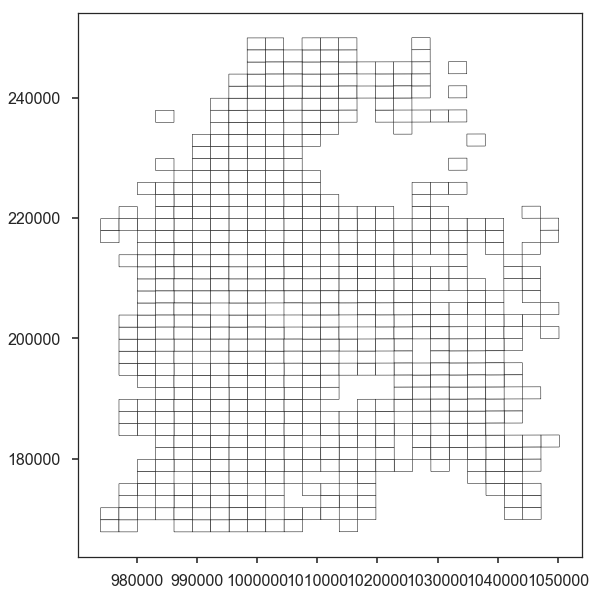

In [186]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
df2.plot(column=None, color="white", edgecolor="black", ax=ax)
plt.savefig('geohash_pickup', dpi=500, transparent=True)
plt.show()

In [153]:
#os.system("curl -O https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip")
#os.system("mv " + "taxi_zones.zip " + os.getenv("PUIDATA"))
#os.system("unzip " + os.getenv("PUIDATA") + "/taxi_zones.zip -d " + os.getenv("PUIDATA") + "/taxi_zones")
#zone = gpd.read_file(os.getenv("PUIDATA") + "/taxi_zones" + "/taxi_zones.shp")
zone = gpd.read_file("./taxi_zones/taxi_zones.shp")
zone.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.9183527103 192536.0856972019,...  
1         Queens  (POLYGON ((1033269.243591294 172126.0078125, 1...  
2          Bronx  POLYGON ((1026308.769506663 256767.6975403726,...  
3      Manhattan  POLYGON ((992073.4667968601 203714.0759887695,...  
4  Staten Island  POLYGON ((935843.3104932606 144283.335850656, ...

No handles with labels found to put in legend.


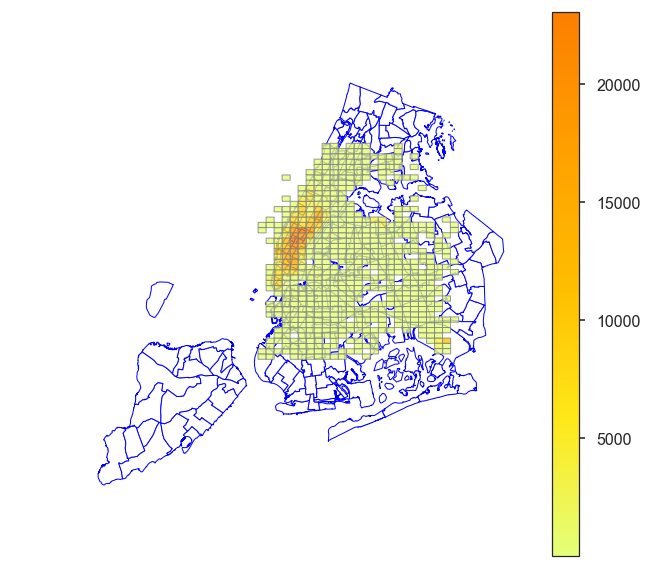

In [196]:
typ = 'fisher_jenks'
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
cp.choroplethNYC(zone, column=None, color="white", edgecolor="blue", lw=1, ax=ax)
df2.plot(column='pickups', cmap='Wistia',  alpha=0.8, edgecolor="grey", linewidth=1,
           ax=ax, legend=True, k=5)
plt.legend(loc=2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.savefig('geohash_pickup', dpi=500, transparent=True)
plt.show()

In [227]:
data["pickup_geohash"] = data["pickup_geohash"].astype('category')
data.dtypes
data["pickup_geohash"] = data["pickup_geohash"].cat.codes
data.head()

date_of_year  month_of_year  day_of_year  pickup_hour    dropoff_datetime  \
0   2016-01-23              1           23           22 2016-01-23 22:28:15   
1   2016-01-23              1           23           22 2016-01-23 22:44:11   
2   2016-01-23              1           23           22 2016-01-23 22:23:43   
8   2016-01-23              1           23           22 2016-01-23 22:34:57   
9   2016-01-23              1           23           22 2016-01-23 22:58:09   

      pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  \
0 2016-01-23 22:18:51        -74.004860        40.706886         -73.989311   
1 2016-01-23 22:38:56        -74.000771        40.718445         -73.999222   
2 2016-01-23 22:14:49        -73.907150        40.760212         -73.898651   
8 2016-01-23 22:29:42        -73.988800        40.722584         -73.983391   
9 2016-01-23 22:37:01        -73.948532        40.633701         -73.968132   

   dropoff_latitude  travel_time       temp  visib  mxpsd  wdsp       gust  \
0         40.721378     9.400000  26.200001    1.7   20.0  12.8  36.900002   
1         40.719875     5.250000  26.200001    1.7   20.0  12.8  36.900002   
2         40.749737     8.900000  26.200001    1.7   20.0  12.8  36.900002   
8         40.729870     5.250000  26.200001    1.7   20.0  12.8  36.900002   
9         40.685219    21.133333  26.200001    1.7   20.0  12.8  36.900002   

    max   min  prcp  sndp  fog  rain_drizzle  snow_ice_pellets  hail  thunder  \
0  30.0  21.0   0.5   0.0    1             0                 1     0        0   
1  30.0  21.0   0.5   0.0    1             0                 1     0        0   
2  30.0  21.0   0.5   0.0    1             0                 1     0        0   
8  30.0  21.0   0.5   0.0    1             0                 1     0        0   
9  30.0  21.0   0.5   0.0    1             0                 1     0        0   

   distance_in_km  weekday  label  pickup_geohash  label3  label2  label4  \
0        1.440539        5      7             601       3      62      93   
1        0.142258        5     47             348       3      62      93   
2        1.134298        5     95             247       3      62      64   
8        0.773974        5     23             346       3      62      25   
9        5.681039        5     50             501       3      62       2   

   label1  
0      14  
1       2  
2      16  
8      17  
9       8

## Split train and test set

In [234]:
#from sklearn.model_selection import TimeSeriesSplit
#tscv = TimeSeriesSplit(n_splits=2)
columns = ['travel_time','date_of_year','dropoff_datetime', 'pickup_datetime','label','label1','label2']
X_test = data[data['pickup_datetime'] >= '2016-06-01 00:00:00'].drop(columns,axis = 1)
Y_test = np.log(data[data['pickup_datetime'] >= '2016-06-01 00:00:00']['travel_time'])
X_train = data[data['pickup_datetime'] < '2016-05-01 00:00:00'].drop(columns,axis=1)
Y_train = np.log(data[data['pickup_datetime'] < '2016-05-01 00:00:00']['travel_time'])
X_valid = data[(data['pickup_datetime'] >= '2016-04-01 00:00:00') & (data['pickup_datetime'] < '2016-06-01 00:00:00')].drop(columns,axis = 1)
Y_valid= np.log(data[(data['pickup_datetime'] >= '2016-04-01 00:00:00') & (data['pickup_datetime'] < '2016-06-01 00:00:00')]['travel_time'])

### XGB

In [203]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

In [199]:
#from sklearn.ensemble import RandomForestRegressor
#rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=50, min_samples_split=75)

In [235]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
#dtest = xgb.DMatrix(X_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [243]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.2, 'colsample_bytree': 0.9, 
            'max_depth': 13, 
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:1.58883	valid-rmse:1.65008
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:1.29556	valid-rmse:1.35496
[2]	train-rmse:1.06143	valid-rmse:1.11765
[3]	train-rmse:0.877464	valid-rmse:0.93187
[4]	train-rmse:0.734456	valid-rmse:0.786174
[5]	train-rmse:0.623937	valid-rmse:0.673563
[6]	train-rmse:0.540485	valid-rmse:0.589768
[7]	train-rmse:0.476052	valid-rmse:0.523875
[8]	train-rmse:0.428556	valid-rmse:0.475102
[9]	train-rmse:0.394466	valid-rmse:0.44109
[10]	train-rmse:0.36841	valid-rmse:0.414671
[11]	train-rmse:0.346616	valid-rmse:0.39399
[12]	train-rmse:0.331821	valid-rmse:0.380535
[13]	train-rmse:0.321247	valid-rmse:0.371454
[14]	train-rmse:0.30979	valid-rmse:0.361848
[15]	train-rmse:0.302519	valid-rmse:0.355713
[16]	train-rmse:0.297512	valid-rmse:0.352145
[17]	train-rmse:0.291932	valid-rmse:0.348886
[18]	train-rmse:0.286733	valid-rmse:0.345455
[19]	train-rmse:0.2830

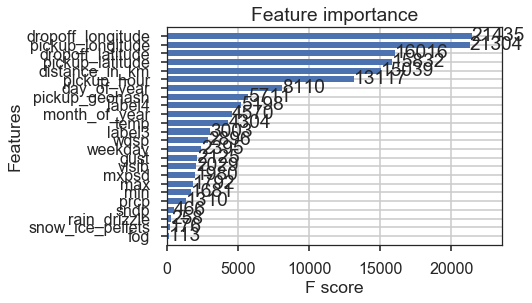

In [244]:
xgb.plot_importance(model, max_num_features=28, height=0.7)